RECORDAR DESZIPEAR PROPERATTI.ZIP

In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv("../dh-ds-pi-1/data/properatti.csv", index_col=0)
data.shape

(121220, 25)

In [3]:
data.dtypes

operation                      object
property_type                  object
place_name                     object
place_with_parent_names        object
country_name                   object
state_name                     object
geonames_id                   float64
lat-lon                        object
lat                           float64
lon                           float64
price                         float64
currency                       object
price_aprox_local_currency    float64
price_aprox_usd               float64
surface_total_in_m2           float64
surface_covered_in_m2         float64
price_usd_per_m2              float64
price_per_m2                  float64
floor                         float64
rooms                         float64
expenses                      float64
properati_url                  object
description                    object
title                          object
image_thumbnail                object
dtype: object

# Verificar si existen filas con todos los datos faltantes - PASAR A ANALISIS INICIAL - REVISAR CODIGO

In [4]:
df_usd_m2 = data['price_usd_per_m2']
mask_nan_uds_m2= df_usd_m2.isna()

In [5]:
mask_nan_sup_total=data["surface_total_in_m2"].isna()
mask_nan_sup_cubierta=data["surface_covered_in_m2"].isna()
mask_nan_rooms=data["rooms"].isna()


In [6]:
mask_nan_columnas = (mask_nan_sup_total == True) & (mask_nan_sup_cubierta == True) &(mask_nan_rooms == True) &(mask_nan_uds_m2 == True) 
mask_nan_columnas.value_counts()

False    113090
True       8130
dtype: int64

#Nota: volver a revisar estos datos despues de haber completado todas las columnas con los datos extraidos del campo descripcion - inicial 8130

## Columna Superficie

## REVISAR CONSISTENCIA DE DATOS PARA LAS COLUMNAS SUP TOTAL Y CUBIERTA!

In [7]:
mask_consistencia_sup = data["surface_total_in_m2"] < data["surface_covered_in_m2"]

In [8]:
data_consistencia_metros=data[mask_consistencia_sup]
print(data_consistencia_metros[['surface_covered_in_m2','surface_total_in_m2']].sample(10))
print(data_consistencia_metros.property_type.value_counts())
print(data.property_type.value_counts())

        surface_covered_in_m2  surface_total_in_m2
67500                    54.0                 45.0
3884                     36.0                 34.0
65706                   150.0                110.0
121055                   98.0                 77.0
9130                    300.0                150.0
29292                   190.0                120.0
108142                   31.0                 11.0
62209                    88.0                 72.0
68754                    75.0                 60.0
65715                   162.0                160.0
house        666
apartment    351
store         47
PH            42
Name: property_type, dtype: int64
apartment    71065
house        40268
PH            5751
store         4136
Name: property_type, dtype: int64


In [9]:
data_consistencia_metros.shape[0]/data.shape[0]

0.009123906946048506

El porcentaje de registros con estos errores es menor al 1%, no hemos podido encontrar un patrón sencillo en estos errores

#### 1- detectar de outliers

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

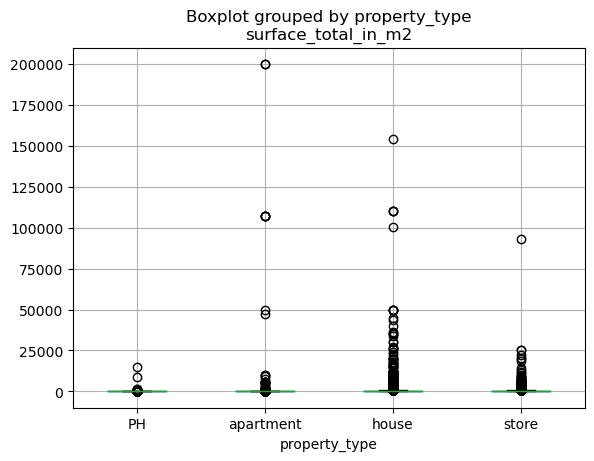

In [11]:
data.boxplot(column= "surface_total_in_m2", by="property_type") 
plt.show()

se detectan outliers para superficies mayores a 75000 m2. ### ver consistencia en outliers

##### VER SI ELIMINAMOS OUTLIERS!!!!

#### 2-Recuperar informacion faltante a través de regex de la columna descripción

In [12]:
import re

In [13]:
serie_descripcion = data["description"]

In [14]:
pattern_sup_m2 = "(?P<sup>\d{2,}(,|.\d+)?)\s*(m2|metros|mts)"
pattern_sup_m2_regex = re.compile(pattern_sup_m2,  re.IGNORECASE)

In [15]:
import numpy as np
sup_match = serie_descripcion.apply(lambda x: x if x is np.NaN else pattern_sup_m2_regex.search(x))


In [16]:
sup_match.sample(10)

115143    <re.Match object; span=(233, 239), match='380 ...
71580                                                  None
81274                                                  None
114153    <re.Match object; span=(168, 173), match='25 M2'>
116182    <re.Match object; span=(193, 198), match='130m2'>
39475                                                  None
9849                                                   None
17463                                                  None
58001                                                  None
77298     <re.Match object; span=(62, 69), match='300 mts'>
Name: description, dtype: object

In [17]:
mask_sup_match_notnull= sup_match.notnull()

data.loc[mask_sup_match_notnull, "Sup_m2_Clean"] = sup_match[mask_sup_match_notnull].apply(lambda x: x.group("sup"))


In [18]:
#data.loc[mask_sup_match_notnull, ["surface_total_in_m2", "surface_covered_in_m2", "Sup_m2_Clean"]]----para borrar

In [19]:
serie_sup_m2_clean=data["Sup_m2_Clean"]

In [20]:
print(serie_sup_m2_clean.notnull().sum())
serie_sup_m2_clean.isnull().sum()

40087


81133

In [21]:
#SE ARREGLAN ERRORES DE COLUMNA DE REGEX PARA PODER SER UTILIZADOS EN ESTADISTICA

pattern_sup_m2_dos="(?P<supdos>\d{2,})"
pattern_sup_m2_regex_dos=re.compile(pattern_sup_m2_dos)
sup_match_dos = serie_sup_m2_clean.apply(lambda x: x if x is np.NaN else pattern_sup_m2_regex_dos.search(x))
mask_sup_match_notnull_dos= sup_match_dos.notnull()
data.loc[mask_sup_match_notnull_dos, "Sup_m2_Clean_dos"] = sup_match_dos[mask_sup_match_notnull_dos].apply(lambda x: x.group("supdos"))
# data["Sup_m2_Clean_dos"].median()


TypeError: expected string or bytes-like object

##### Se supone que para PH, apartments y store la superficie cubierta es la misma que la superficie total, *se descarta house entendiendo que estas pueden contar con "patio". con estos datos se reemplazan los valores faltantes(no lo pude separar -VER!!!!*. PASAR PARA ARRIBA para dar orden al analisis

In [ ]:
data_limpia= data.copy()


In [ ]:
data_limpia["sup_m2_total_limpia"] = data_limpia["surface_total_in_m2"]

In [ ]:
data_key_not_null_mask = np.logical_and(data.property_type.notnull(), data.surface_covered_in_m2.notnull())
data_key_not_null = data.loc[data_key_not_null_mask, :]
data_key_not_null.shape

(101313, 26)

In [ ]:
data_key_not_null_grouped_tipo_sup= data_key_not_null.groupby(["property_type", "surface_covered_in_m2"])


In [ ]:
data_fillna= data_key_not_null_grouped_tipo_sup["surface_total_in_m2"].transform(lambda grp: grp.fillna(grp.mean()))
data_fillna

0          55.0
2          55.0
4          35.0
6         106.0
7          45.0
          ...  
121215    113.0
121216    360.0
121217     46.0
121218     48.0
121219     77.0
Name: surface_total_in_m2, Length: 101313, dtype: float64

In [ ]:
data_limpia["sup_m2_total_limpia"].fillna(data_fillna,inplace=True)
#data_limpia.loc[mask_sup_match_notnull, ["surface_total_in_m2", "sup_m2_total_limpia", "property_type"]]

In [ ]:
data_limpia["sup_m2_total_limpia"].isnull().sum()

12642

### se adicionan los datos obtenidos de la columna descripcion.

In [ ]:
data_limpia["sup_m2_total_limpia"].fillna(data_limpia["Sup_m2_Clean_dos"],inplace=True)

KeyError: 'Sup_m2_Clean_dos'

In [ ]:
data_limpia["sup_m2_total_limpia"].isnull().sum()/data["surface_total_in_m2"].isnull().sum()*100

32.14503661513425

### se recupera el 23% de la informacion faltante al suponer superficie cubierta como superficie total y al extraer informacion con metodo regex de la columna descripción 


In [ ]:
data_limpia["sup_m2_total_limpia"].isnull().sum()/data_limpia.shape[0]*100

10.428972116812407

#### se redujo de 32% a 7.6% la información faltante.

# Para los datos faltantes en la columna de interés, se desea agrupar por tipo de propiedad para sacar la mediana de los m2 totales y estratificar los valores. de esta manera podriamos tener los datos completos. REVISAR SI ES NECESARIO

# Columna Rooms

### Revisar relacion precio vs rooms. comparar propiedades similares con distinta cantidad de rooms para ver si varia sustancialmente el precio - PENDIENTE

In [22]:
## Arranco por los monoambientes
#pattern_mono='(?P<sup>\d{2,}(,|.\d+)?)\s*(mono)\S+?'
pattern_mono='(mono)|(mono\s+\w+)|(mono\.+\w+)|(mono\-+\w+)|(mono\w+)'
pattern_mono_regex=re.compile(pattern_mono,re.IGNORECASE)

In [23]:
serie_mono_descripcion=data['description']
mono_match = serie_mono_descripcion.apply(lambda x: x if x is np.NaN else pattern_mono_regex.search(x))
#sup_match = serie_descripcion.apply(lambda x: x if x is np.NaN else pattern_sup_m2_regex.search(x))


In [24]:
mask_mono_match=mono_match.notnull()
col_mono_prueba_nulos=mono_match[mask_mono_match]
col_mono_prueba_nulos.shape

(10749,)

In [25]:
data.loc[mask_mono_match,'Ambientes_Clean']= 1

#### Ahora me enfoco en todos los departamentos que no sean monos, uso por ahora ambientes, para evitar confusiones con dormitorios y habitaciones

In [26]:
#pattern_rooms= "(?P<dorm>\d+.?Dorm|\d+.?dorm|\d+.?DORM|\d+.?AMB|\d+.?Amb|\d+.?amb|\d+.?hab|\d+.?HAB|\d+.?Hab|monoamb)"
#pattern_rooms= "(?P<dorm>\d{2,}(,|.\d+)?)\s*(Dorm|amb|monoamb).?Dorm|\d+.?dorm|\d+.?DORM|\d+.?AMB|\d+.?Amb|\d+.?amb|\d+.?hab|\d+.?HAB|\d+.?Hab|monoamb)"
#"(?P<sup>\d{2,}(,|.\d+)?)\s*(m2|metros|mts)"(mono)|(mono\s+\w+)|(mono\.+\w+)|(mono\-+\w+)|(mono\w+)
#"(?P<sup>\d{2,}(,|.\d+)?)\s*(m2|metros|mts)"
pattern_ambs="(?P<num>\s\d{1,2})\s*(\samb\w*\s)"
pattern_ambs_regex=re.compile(pattern_ambs,re.IGNORECASE)

In [27]:
mask_mono_nulo=mono_match.isnull()
col_mono_nulo=mono_match[mask_mono_nulo]
pattern_ambs_match=serie_descripcion.apply(lambda x: x if x is np.NaN else pattern_ambs_regex.search(x))

In [28]:
pattern_ambs_match.value_counts()

<re.Match object; span=(25, 38), match=' 4 ambientes '>      1
<re.Match object; span=(15, 28), match=' 2 ambientes '>      1
<re.Match object; span=(352, 365), match=' 2 ambientes '>    1
<re.Match object; span=(134, 147), match=' 5 ambientes '>    1
<re.Match object; span=(6, 19), match=' 4 ambientes '>       1
                                                            ..
<re.Match object; span=(35, 48), match=' 4 ambientes '>      1
<re.Match object; span=(199, 212), match=' 3 AMBIENTES '>    1
<re.Match object; span=(166, 173), match=' 1 amb '>          1
<re.Match object; span=(5, 12), match=' 2 amb '>             1
<re.Match object; span=(118, 131), match=' 4 ambientes '>    1
Name: description, Length: 27506, dtype: int64

In [29]:
type(pattern_ambs_match)

pandas.core.series.Series

In [30]:
print(pattern_ambs_match.isna().sum())
print(pattern_ambs_match.notna().sum())

93714
27506


In [31]:
#Cambio los None por NaN
pattern_ambs_match_2=pattern_ambs_match.fillna(np.NaN)

In [32]:
pattern_ambs_match_3=pattern_ambs_match_2.apply(lambda x: x if x is np.NaN else x[0])

In [33]:
nuevo_pattern='(?P<num>\d{1,2})'
nuevo_pattern_regex=re.compile(nuevo_pattern)
nuevo_pattern_match=pattern_ambs_match_3.apply(lambda x: x if x is np.NaN else nuevo_pattern_regex.search(x))
nuevo_pattern_match.notnull().sum()

27506

In [34]:
mask_def_not_null= nuevo_pattern_match.notnull()
mask_mono_nulo=mono_match.isnull()
data.loc[mask_mono_nulo, "Ambientes_Clean"] = nuevo_pattern_match[mask_mono_nulo].apply(lambda x: x if x is np.NaN else x.group('num'))


In [35]:
serie_rooms_clean=data["Ambientes_Clean"]
serie_rooms_clean.notnull().sum()
serie_rooms_clean.value_counts()
data[['Ambientes_Clean','rooms']].sample(10)

,Ambientes_Clean,rooms
118899,1,NaN
85015,3,NaN
41204,NaN,4.0
116886,NaN,NaN
30033,1,3.0
107079,NaN,NaN
119258,1,2.0
105150,1,NaN
46636,NaN,4.0
2994,NaN,5.0


In [36]:
mask_room_no_nula = data.rooms.notnull()
data.Ambientes_Clean[mask_room_no_nula]=data.rooms[mask_room_no_nula]
data[['Ambientes_Clean','rooms']][mask_room_no_nula]

C:\Users\idfic\AppData\Local\Temp\ipykernel_21172\457002546.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.Ambientes_Clean[mask_room_no_nula]=data.rooms[mask_room_no_nula]


,Ambientes_Clean,rooms
13,1,1.0
14,1,1.0
16,4,4.0
17,3,3.0
19,3,3.0
...,...,...
120203,2,2.0
120204,1,1.0
120205,5,5.0
120206,4,4.0


In [37]:
#Pctje no nulo de rooms
print(data.Ambientes_Clean.notnull().sum()/data.shape[0])
print(data.rooms.notnull().sum()/data.shape[0])

0.5491585546939449
0.3909420887642303


Recuperamos el 16% de rooms

Procedo a imputar los ambientes

In [38]:
mask_amb_not_null=data.Ambientes_Clean.notnull()
data.loc[mask_amb_not_null,'Ambientes_Clean']=data.loc[mask_amb_not_null,'Ambientes_Clean'].astype('int')

In [39]:
data.Ambientes_Clean=data.Ambientes_Clean.astype('Int64')

In [40]:
ambientes_non_null=data.Ambientes_Clean[mask_amb_not_null]
metros_mask_amb_non_null=data.surface_covered_in_m2[mask_amb_not_null]

In [41]:
data.surface_covered_in_m2=data.surface_covered_in_m2.astype('Int64')
data[['Ambientes_Clean','surface_covered_in_m2']].dtypes

Ambientes_Clean          Int64
surface_covered_in_m2    Int64
dtype: object

In [42]:
data['size_rooms']=np.where(data['Ambientes_Clean'].notnull(),data['surface_covered_in_m2']/data['Ambientes_Clean'],np.NaN)

In [43]:
data[['Ambientes_Clean','surface_covered_in_m2','size_rooms']]

,Ambientes_Clean,surface_covered_in_m2,size_rooms
0,<NA>,40,NaN
1,<NA>,<NA>,NaN
2,<NA>,55,NaN
3,3,<NA>,NaN
4,<NA>,35,NaN
...,...,...,...
121215,<NA>,93,NaN
121216,<NA>,360,NaN
121217,1,39,39.0
121218,<NA>,48,NaN


# Ahora completo los faltantes de tamaño promedio con groupby

In [44]:
fill_values=data.groupby('property_type').size_rooms.median()

In [45]:
fill_values_df=pd.DataFrame(fill_values)
fill_values_df.reset_index(inplace=True)
fill_values_df.head(5)

,property_type,size_rooms
0,PH,23.50
1,apartment,26.00
2,house,40.00
3,store,57.75


In [46]:
#Lo mergeamos con el df
data = data.merge(fill_values_df,on='property_type',suffixes=('','_median'),how='left')
data.sample(10)

,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,lon,...,rooms,expenses,properati_url,description,title,image_thumbnail,Sup_m2_Clean,Ambientes_Clean,size_rooms,size_rooms_median
18511,sell,apartment,Villa Crespo,|Argentina|Capital Federal|Villa Crespo|,Argentina,Capital Federal,3427458.0,"-34.6030405,-58.435675",-34.603041,-58.435675,...,2.0,NaN,http://www.properati.com.ar/1773n_venta_depart...,TRIPLEX DE 2 AMBIENTES CON TERRAZA PROPIA. A E...,DEPARTAMENTO EN VENTA VILLA CRESPO TRIPLEX,https://thumbs4.properati.com/1/tjHLfKvE2ZtzJ7...,18,2,21.500000,26.0
112672,sell,house,Pilar del Lago,|Argentina|Bs.As. G.B.A. Zona Norte|Pilar|Pila...,Argentina,Bs.As. G.B.A. Zona Norte,NaN,NaN,NaN,NaN,...,NaN,2300.0,http://www.properati.com.ar/1c77i_venta_casa_p...,"Sobre terreno de 800 mts, construida una casa ...",Casa - Pilar Del Lago,https://thumbs4.properati.com/0/J7BSr1B7yW0C-n...,800,<NA>,NaN,40.0
91033,sell,apartment,Olivos,|Argentina|Bs.As. G.B.A. Zona Norte|Vicente Ló...,Argentina,Bs.As. G.B.A. Zona Norte,3430310.0,NaN,NaN,NaN,...,NaN,NaN,http://www.properati.com.ar/1bb0g_venta_depart...,Dto 2 amb apto profesional a estrenar exc est...,Departamento en Olivos,https://thumbs4.properati.com/6/Hk1jbXch77n1sW...,50,2,25.000000,26.0
5723,sell,apartment,Rosario,|Argentina|Santa Fe|Rosario|,Argentina,Santa Fe,3838574.0,"-32.9371824,-60.6418905",-32.937182,-60.641891,...,NaN,NaN,http://www.properati.com.ar/15rjy_venta_depart...,CODIGO: 3855-JP-000053 ubicado en: Jujuy 1515 ...,Departamento 2 dormitorios en venta en Rosario...,https://thumbs4.properati.com/1/OgVNnZ6KdUTWa1...,"50,55",<NA>,NaN,26.0
7974,sell,apartment,Caballito,|Argentina|Capital Federal|Caballito|,Argentina,Capital Federal,3435874.0,"-34.6058091,-58.4534805",-34.605809,-58.453481,...,3.0,NaN,http://www.properati.com.ar/15znx_venta_depart...,"Emprendimiento ícono en la zona, Caballito Nor...",Departamento - Caballito Norte,https://thumbs4.properati.com/1/YN9StXiLKv20MH...,NaN,3,22.666667,26.0
67481,sell,apartment,Remedios de Escalada,|Argentina|Bs.As. G.B.A. Zona Sur|Lanús|Remedi...,Argentina,Bs.As. G.B.A. Zona Sur,3429582.0,NaN,NaN,NaN,...,NaN,NaN,http://www.properati.com.ar/1afcl_venta_depart...,El complejo cuenta con una parrilla en el fond...,Departamento en Remedios De Escalada,https://thumbs4.properati.com/9/AuQktn0HPaKuMe...,NaN,<NA>,NaN,26.0
68185,sell,apartment,San Miguel de Tucumán,|Argentina|Tucumán|San Miguel de Tucumán|,Argentina,Tucumán,3836873.0,NaN,NaN,NaN,...,NaN,NaN,http://www.properati.com.ar/1aggu_venta_depart...,ENTREGA DICIEMBRE 2017.Para el proyecto se ado...,Departamento - Barrio Norte,https://thumbs4.properati.com/9/aQdciZHPyKUqBc...,"423,50",1,57.000000,26.0
84329,sell,house,Escobar,|Argentina|Bs.As. G.B.A. Zona Norte|Escobar|,Argentina,Bs.As. G.B.A. Zona Norte,3434130.0,NaN,NaN,NaN,...,NaN,5000.0,http://www.properati.com.ar/1b1lm_venta_casa_e...,EXCELENTE CASA DE MODERNO DISEÑO A LAGUNA! Se ...,Casa en venta a estrenar a la Laguna en Barrio...,https://thumbs4.properati.com/2/KpVvWVznOONd5M...,NaN,<NA>,NaN,40.0
77526,sell,house,General Pacheco,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre|Gene...,Argentina,Bs.As. G.B.A. Zona Norte,3433787.0,NaN,NaN,NaN,...,NaN,NaN,http://www.properati.com.ar/1asxw_venta_casa_g...,CASA EN VENTA EN GENERAL PACHECO - TIGRECompue...,CASA EN VENTA EN GENERAL PACHECO - TIGRE - POZ...,https://thumbs4.properati.com/6/1mv8oAlbB2wYkZ...,10,<NA>,NaN,40.0
37480,sell,apartment,Lanús,|Argentina|Bs.As. G.B.A. Zona Sur|Lanús|Lanús|,Argentina,Bs.As. G.B.A. Zona Sur,NaN,"-34.711961,-58.392447",-34.711961,-58.392447,...,2.0,NaN,http://www.properati.com.ar/18j99_venta_depart...,Corredor Responsable: Marcelo Trujillo - CUCIC...,Departamento - 2 ambientes - Apto Crédito,https://thumbs4.properati.com/2/dXgW2gGPfYXc9L...,NaN,2,26.000000,26.0


In [47]:
data.size_rooms.fillna(data.size_rooms_median,inplace=True)

In [48]:
mask_ambientes_null=data.Ambientes_Clean.isnull()

In [49]:
data['ambientes_2']=data.surface_covered_in_m2/data.size_rooms
#data['ambientes_2']=data['ambientes_2'].astype('Int64')
data['ambientes_2'].dtype
data['Ambientes_Clean']=data['Ambientes_Clean'].astype('float64')
data['Ambientes_Clean'].dtype
data.Ambientes_Clean.fillna(data.ambientes_2,inplace=True)


In [50]:
print(data.Ambientes_Clean.notnull().sum()/data.shape[0])
print(data.rooms.notnull().sum()/data.shape[0])

0.9079607325523841
0.3909420887642303


# Se logró imputar el 90% de Rooms!!! Si reemplazamos los m2_covered por los m2 imputados podemos lograr el 90%

### se saca la parte entera del str

In [ ]:
pattern_rooms_dos="(?P<dorm_dos>\d+.?)"
pattern_rooms_regex_dos=re.compile(pattern_rooms_dos)
room_match_dos = serie_rooms_clean.apply(lambda x: x if x is np.NaN else pattern_rooms_regex_dos.search(x))
room_match_dos.sample(10)

NameError: name 'serie_rooms_clean' is not defined

In [ ]:
mask_room_match_notnull_dos= room_match_dos.notnull()

data.loc[mask_room_match_notnull_dos,"rooms_clean_dos"] = room_match_dos[mask_room_match_notnull_dos].apply(lambda x: x.group(0))

In [ ]:
data.loc[mask_room_match_notnull_dos, ["rooms", "rooms_clean_dos"]]

In [ ]:
data_limpia["rooms"].fillna(data_limpia["rooms_clean_dos"],inplace=True)
data_limpia

% de info recuperada = 46%

In [ ]:
data_limpia["rooms"].isnull().sum()/data["rooms"].isnull().sum()*100

NameError: name 'data_limpia' is not defined

In [ ]:
mask_residencial= data.property_type != 'store'
tipos_residenciales=data.property_type[mask_residencial]
rooms_residenciales=data.rooms[mask_residencial]
df_residencial=pd.DataFrame(tipos_residenciales)
df_residencial['rooms']=rooms_residenciales

##### Intentamos ver si los datos faltantes de rooms disminuyen si descontamos las tiendas

In [ ]:
data.rooms.value_counts()

In [ ]:
shape_df=df_residencial.shape
count_res=shape_df[0]


In [ ]:
nulos_room=df_residencial.rooms.isna().sum(axis=0)
pctje_nulos_rooms=nulos_room/count_res
pctje_nulos_rooms

Veamos cuantas rooms tienen las tiendas

In [ ]:
mask_comercial= data.property_type == 'store'
tipos_comerciales=data.property_type[mask_comercial]
rooms_comerciales=data.rooms[mask_comercial]
df_comercial=pd.DataFrame(tipos_comerciales)
df_comercial['rooms']=rooms_comerciales
df_comercial.rooms.value_counts()

#### Recordemos que el porcentaje original de nulos era similar, 

Veamos si los faltantes de expensas disminuyen sacando tiendas y casas

In [ ]:
mascara_sin_casas=df_residencial.property_type !='house'
expensas_residenciales=data.expenses[mask_residencial]
df_residencial['expenses']=expensas_residenciales
expensas_deps_ph=expensas_residenciales[mascara_sin_casas]
null_exp_clean=expensas_deps_ph.isnull().sum()
shape_exp_clean=expensas_deps_ph.shape
pctje_null_exp_clean=null_exp_clean/shape_exp_clean[0]
pctje_null_exp_clean
type_deps_ph=df_residencial.property_type[mascara_sin_casas]
type_deps_ph.value_counts()

In [ ]:
expensas_deps_ph.isnull().sum()/expensas_deps_ph.shape[0]

Probemos ahora sacando los nulos de rooms para tratar de aplicar un promedio del tamaño de las rooms

In [ ]:
mask_rooms_no_nulas=data.rooms.notnull()
rooms_no_nulas=data.rooms.loc[mask_rooms_no_nulas]
sf_room_no_nulas=data.surface_covered_in_m2.loc[mask_rooms_no_nulas]
df_rooms_clean=pd.DataFrame(rooms_no_nulas)
df_rooms_clean['m2_covered']=sf_room_no_nulas
mask_rooms_no_nulas.value_counts()

El pctje de m2 cubiertos es ligeramente menor, por lo que no hay mucha correlacion entre nulidad de rooms y nulidad de m2_covered
Hay que inputar los m2 cubiertos faltantes antes de poder avanzar a tener un promedio de cuantos m2 tiene cada habitación
Para imputar las rooms, me imagino hay que inputar promedio por tipo de propiedad, hace falta por barrio, o alguna caracteristica extra?? Para mi no hace falta

# Recuperar datos de precio total en dolares

### REVISAR CONSISTENCIA ENTRE DATOS ARS Y USD

### Nos centramos en este campo, por dos motivos. Sabiendo que la finalidad de esta limpieza es lograr obtener una base de datos con valores que me permitan luego armar un modelo que me ayude a determinar el valor de una propiedad, entendemos que el campo precio es el mas importante. Uno de los motivos por el cual nos centramos en el precio en dolares, es porque este campo no se ve influenciado por la inflación, por otro lado contamos con bastantes datos en la columna lo cual disminuye el error por supuestos o calculos mal hechos.

### 1-Extraer información con regex de columna descripción

In [ ]:
import re
serie_descripcion = data["description"]

pattern_usd = "(?P<usd>(usd|u[$]d)\s*?(\d{2,}(,|.\d+)?))"
pattern_usd_regex = re.compile(pattern_usd,  re.IGNORECASE)

import numpy as np
usd_match = serie_descripcion.apply(lambda x: x if x is np.NaN else pattern_usd_regex.search(x))

mask_usd_match_notnull= usd_match.notnull()

data.loc[mask_usd_match_notnull, "usd_clean"] = usd_match[mask_usd_match_notnull].apply(lambda x: x.group(0))


In [ ]:
serie_usd_clean=data["usd_clean"]

In [ ]:
pattern_usd_dos="(?P<usddos>(\d{2,}(,|.\d+)?))"
pattern_usd_regex_dos=re.compile(pattern_usd_dos)
usd_match_dos = serie_usd_clean.apply(lambda x: x if x is np.NaN else pattern_usd_regex_dos.search(x))
mask_usd_match_notnull_dos= usd_match_dos.notnull()
data.loc[mask_usd_match_notnull_dos, "usd_clean_dos"] = usd_match_dos[mask_usd_match_notnull_dos].apply(lambda x: x.group("usddos"))


In [ ]:
data_limpia["precio_usd_limpio"]=data_limpia["price_aprox_usd"]

In [ ]:
data_limpia["precio_usd_limpio"].fillna(data_limpia["usd_clean_dos"],inplace=True)

In [ ]:
data_limpia["precio_usd_limpio"].isnull().sum()

In [ ]:
(1-data_limpia["precio_usd_limpio"].isnull().sum()/data["price_aprox_usd"].isnull().sum())*100

Se recuperó el 1.2% de la informacion de precios en dolares del campo descripcion. La recuperacion de datos no es significativa.

### 2-comprobar si las columnas precio ARS y USD pueden matchear- listo

In [ ]:
mask_ARS_empty=data["price_aprox_local_currency"].isnull()
mask_ARS_empty.value_counts()

In [ ]:
mask_USD_empty=data["price_aprox_usd"].isnull()
mask_USD_empty.value_counts()

In [ ]:
mask_precio_empty=mask_ARS_empty&mask_USD_empty
data[mask_precio_empty].shape

##### coinciden la cantidad de filas vacias en cada campo, por lo cual no es posible completar completar datos vacios de USD con ARS sacados de la columna "price_aprox_local_currency"

### 3-Determinar la variacion precio con rooms y superficie---- ver de pasar arriba

calculamos la correlacion entre variables

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
df_surf_float = data["surface_total_in_m2"].astype(float) 
df_room_float = data['rooms'].astype(float) 
df_price_float = data['price_aprox_usd'].astype(float) 
df_tipo = data['property_type']

In [ ]:
data_tipo_usd_sup_room=pd.DataFrame((df_tipo,df_surf_float,df_room_float,df_price_float))
data_tipo_usd_sup_room_T=data_tipo_usd_sup_room.T
data_tipo_usd_sup_room_T.sample(10)

In [ ]:
g = sns.PairGrid(data_tipo_usd_sup_room_T, vars=['property_type','surface_total_in_m2','rooms','price_aprox_usd'],hue='property_type', palette='deep')
g.map(plt.scatter, alpha=0.6)
g.add_legend()

#### Se puede ver una relacion entre precio tipo de departamento y superficie, no asi con la cantidad de habitaciones-REVISAR

*nota: cambiar a data_limpia cuando arreglemos el problema de regex de esa columna para obtener datos no influenciados por los datos faltantes

### 4-Calcular el precio total = Precio u$d/m2 * Superficie en base al punto anterior para las filas con datos faltantes

#NOTA: EVALUAR ELIMINAR LOS VALORES Q NO SON PESOS ARGENTINOS PARA PODER HACER UNA CONVERSION DE TODOS LOS VALORES A USD - PENDIENTE

#Se toma el valor medio del precio de propiedad por tipo de propiedad y se completan faltantes.

In [ ]:
data_key_not_null_mask_precio = np.logical_and(data.property_type.notnull(), data.price_aprox_usd.notnull())
data_key_not_null_precio = data.loc[data_key_not_null_mask, :]

data_key_not_null_grouped_tipo_precio= data_key_not_null_precio.groupby(["property_type", 'price_aprox_usd'])


data_fillna_precio= data_key_not_null_grouped_tipo_precio['price_aprox_usd'].transform(lambda grp: grp.fillna(grp.mean()))
data_fillna_precio

data_limpia["precio_usd_limpio"].fillna(data_fillna,inplace=True)

In [ ]:
(1-data_limpia["precio_usd_limpio"].isnull().sum()/data["price_aprox_usd"].isnull().sum())*100

Se recupera el 67% de la informacion faltante 

In [ ]:
data_limpia["precio_usd_limpio"].isnull().sum()/data_limpia.shape[0]*100

queda el 5.5% de la columna con faltantes.

Cálculo cambio entre ARS y USD 

In [ ]:
import numpy as np
change = data['price_aprox_local_currency'] / data['price_aprox_usd']
change.median()

In [51]:
print(data.surface_covered_in_m2.notnull().sum()/data.shape[0])
print(data.surface_total_in_m2.notnull().sum()/data.shape[0])

0.8357779244349117
0.6755650882692625


## Procedemos a imputar los m2 faltantes de total como = covered para 

In [52]:
data['coef_ajuste_m2']=np.where(data['surface_covered_in_m2'].notnull(),data['surface_total_in_m2']/data['surface_covered_in_m2'],np.NaN)

In [53]:
data.coef_ajuste_m2.sample(5)

15400     1.155556
11377     1.047619
7195      1.000000
120336    1.093750
119597    2.352941
Name: coef_ajuste_m2, dtype: float64

In [54]:
#Ahora los agrupo por groupby
fill_values_m2=data.groupby('property_type').coef_ajuste_m2.median()

In [55]:
fill_values_m2_df=pd.DataFrame(fill_values_m2)
fill_values_m2_df.reset_index(inplace=True)
fill_values_m2_df.head(5)

,property_type,coef_ajuste_m2
0,PH,1.184211
1,apartment,1.092593
2,house,1.250000
3,store,1.000000


In [56]:
data = data.merge(fill_values_m2_df,on='property_type',suffixes=('','_median'),how='left')
data.sample(5)

,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,lon,...,description,title,image_thumbnail,Sup_m2_Clean,Ambientes_Clean,size_rooms,size_rooms_median,ambientes_2,coef_ajuste_m2,coef_ajuste_m2_median
84765,sell,apartment,Palermo Hollywood,|Argentina|Capital Federal|Palermo|Palermo Hol...,Argentina,Capital Federal,NaN,NaN,NaN,NaN,...,"Torre de 18 pisos con unidades de 1, 2, 3 y 4 ...",Departamento - Palermo Hollywood,https://thumbs4.properati.com/3/aCRQrbgu-Zfo8j...,500,4.000,9.00,26.0,4.000,1.138889,1.092593
115193,sell,house,Córdoba,|Argentina|Córdoba|,Argentina,Córdoba,3860255.0,NaN,NaN,NaN,...,LA AURORA.-28 HAS.-Alambrado perimetral.-Sob...,CAMPO AGRICOLA :: MEDIA NARANJA 28 HAS,https://thumbs4.properati.com/9/zeYr2dtf4ooDCM...,NaN,1.000,40.00,40.0,NaN,NaN,1.250000
19224,sell,house,San Justo,|Argentina|Bs.As. G.B.A. Zona Oeste|La Matanza...,Argentina,Bs.As. G.B.A. Zona Oeste,3428775.0,"-34.6904008,-58.565581",-34.690401,-58.565581,...,Casa en Venta de 4 ambientes en Villa Construc...,Figueroa Alcorta 3700 - San Justo - La Matanza,https://thumbs4.properati.com/6/uXXx2qwCWvJL7C...,300,4.000,19.25,40.0,4.000,1.000000,1.250000
81680,sell,house,Banfield,|Argentina|Bs.As. G.B.A. Zona Sur|Lomas de Zam...,Argentina,Bs.As. G.B.A. Zona Sur,3436152.0,"-34.7399907,-58.4091729",-34.739991,-58.409173,...,"Amplio triplex al frente con cochera un auto ,...",DUPLEX,https://thumbs4.properati.com/4/2mrcBP5VTRVmC2...,NaN,3.125,40.00,40.0,3.125,1.000000,1.250000
54022,sell,house,El Molino,|Argentina|Bs.As. G.B.A. Zona Norte|Pilar|El M...,Argentina,Bs.As. G.B.A. Zona Norte,NaN,NaN,NaN,NaN,...,El Molino - Pilar - En planta baja se encuentr...,Bustamante Propiedades | El Molino en Venta,https://thumbs4.properati.com/1/asRJVGRezTCXCw...,NaN,4.250,40.00,40.0,4.250,4.741176,1.250000


In [57]:
#Relleno los nan del coef
data.coef_ajuste_m2.fillna(data.coef_ajuste_m2_median,inplace=True)

In [60]:
data['m2_total_ajust']=np.where(data['surface_total_in_m2'].isnull(),data['coef_ajuste_m2']*data['surface_covered_in_m2'],data['surface_total_in_m2'])

In [61]:
data.m2_total_ajust.notnull().sum()

108851

In [62]:
print(data.surface_covered_in_m2.notnull().sum()/data.shape[0])
print(data.m2_total_ajust.notnull().sum()/data.shape[0])

0.8357779244349117
0.897962382445141
